## Analysis

In [62]:
import pandas as pd

# Cargar el dataset
dataset = pd.read_csv('../dataset/Mosaico/dataset.csv')

# Ruta donde están las imágenes
image_folder_path = '../dataset/Mosaico/Imagenes/'

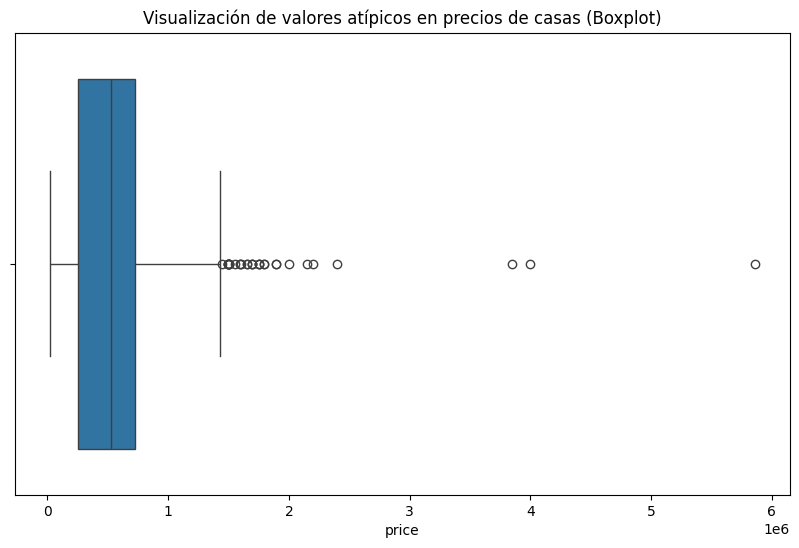

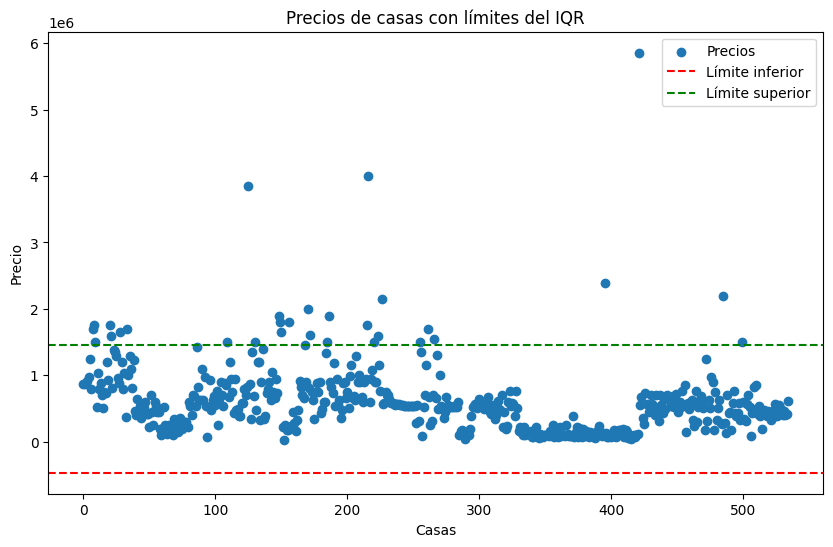

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular el IQR (rango intercuartílico) para la columna de precios
Q1 = dataset['price'].quantile(0.25)
Q3 = dataset['price'].quantile(0.75)
IQR = Q3 - Q1

# Definir umbrales para los precios (1.5 veces el IQR por debajo de Q1 y por encima de Q3)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Boxplot para visualizar los valores atípicos en el precio de las casas
plt.figure(figsize=(10, 6))
sns.boxplot(x=dataset['price'])
plt.title("Visualización de valores atípicos en precios de casas (Boxplot)")
plt.show()

# Scatter plot mostrando los precios con los límites inferior y superior
plt.figure(figsize=(10, 6))
plt.scatter(range(len(dataset)), dataset['price'], label='Precios')
plt.axhline(y=lower_bound, color='r', linestyle='--', label='Límite inferior')
plt.axhline(y=upper_bound, color='g', linestyle='--', label='Límite superior')
plt.title("Precios de casas con límites del IQR")
plt.xlabel("Casas")
plt.ylabel("Precio")
plt.legend()
plt.show()


In [64]:
# Imprimir los umbrales inferior y superior
print(f"Limite inferior: {lower_bound}, Limite superior: {upper_bound}")

# Filtrar el dataset para eliminar los valores atípicos
filtered_dataset = dataset[(dataset['price'] >= lower_bound) & (dataset['price'] <= upper_bound)]

print(f"Dataset original: {len(dataset)} filas, Dataset filtrado: {len(filtered_dataset)} filas\n")

# Encontrar el precio mas alto y el mas bajo del dataset original
max_price_original = dataset['price'].max()
min_price_original = dataset['price'].min()

# Encontrar el precio mas alto y el mas bajo del dataset filtrado
max_price = filtered_dataset['price'].max()
min_price = filtered_dataset['price'].min()

# Imprimir los precios más altos y más bajos en ambos datasets
print("| Precios de casas en el dataset original |".center(60, '='))
print(f"Precio más alto en el dataset original: {max_price_original}")
print(f"Precio más bajo en el dataset original: {min_price_original}\n")

print("| Precios de casas en el dataset filtrado |".center(60, '='))
print(f"Precio más alto en el dataset filtrado: {max_price}")
print(f"Precio más bajo en el dataset filtrado: {min_price}\n")


Limite inferior: -469750.0, Limite superior: 1447450.0
Dataset original: 535 filas, Dataset filtrado: 504 filas

========| Precios de casas en el dataset original |=========
Precio más alto en el dataset original: 5858000
Precio más bajo en el dataset original: 22000

========| Precios de casas en el dataset filtrado |=========
Precio más alto en el dataset filtrado: 1430000
Precio más bajo en el dataset filtrado: 22000



## RestNet50

In [ ]:
"""
Dataset completo MAE: 222694.7736448598
Dataset filtrado con MAE: 145956.60990099006

MAE usando solo datos tabulares: 165100.09
Rango de precios: (22000, 5858000)
Mean Absolute Percentage Error (MAPE): 35.00%

MAE usando solo datos tabulares: 108271.21
Rango de precios: (22000, 1430000)
Mean Absolute Percentage Error (MAPE): 27.78%
"""

### All features

In [66]:
import os
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler


In [67]:
# Modelo preentrenado ResNet50 para extraer características
resnet50 = models.resnet50(pretrained=True)
# Quitamos la última capa (fully connected) para obtener un vector de características
resnet50 = torch.nn.Sequential(*list(resnet50.children())[:-1])
resnet50.eval()

c:\Users\uriel\OneDrive\Escritorio\Uriel\IPN\ESCOM\TT\Codigo\my_code\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [68]:
# Transformaciones necesarias para las imágenes (resize, normalize, etc.)
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Función para extraer las características de una imagen usando ResNet50
def extract_image_features(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        img = image_transforms(img).unsqueeze(0)  # Añadimos un batch dimension
        with torch.no_grad():
            features = resnet50(img)
        return features.squeeze().numpy()
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Proceso de extracción de características de todas las imágenes en el dataset
def extract_features_for_dataset(dataset):
    image_features = []
    for img_name in dataset['mosaic_image']:
        img_path = os.path.join(image_folder_path, img_name)
        features = extract_image_features(img_path)
        if features is not None:
            image_features.append(features)
        else:
            # Si hay un problema con la imagen, añadimos un vector de ceros
            image_features.append(np.zeros(2048))  # ResNet50 devuelve un vector de 2048 características
    return np.array(image_features)

In [69]:
# Extraer las características de las imágenes en el dataset
image_features = extract_features_for_dataset(filtered_dataset)

# Concatenar características visuales con datos tabulares
tabular_data = filtered_dataset[['bedrooms', 'bathrooms', 'area', 'zipcode']].values

# Normalizamos las características numéricas con MinMaxScaler
scaler = MinMaxScaler()
tabular_data_normalized = scaler.fit_transform(tabular_data)

X_normalized = np.concatenate([tabular_data_normalized, image_features], axis=1)
y = filtered_dataset['price'].values

# Dividir los datos en conjunto de entrenamiento y prueba
X_train_norm, X_test_norm, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Entrenamos el modelo de regresión Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_norm, y_train)

# Evaluar el modelo en el conjunto de prueba
y_pred_norm = model.predict(X_test_norm)
mae_norm = mean_absolute_error(y_test, y_pred_norm)

print(f'Mean Absolute Error (MAE): {mae_norm}')


Mean Absolute Error (MAE): 145956.60990099006


### Only numeric data

In [88]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

# Seleccionamos las columnas tabulares que utilizaremos (bedrooms, bathrooms, area, zipcode)
tabular_data = filtered_dataset[['bedrooms', 'bathrooms', 'area', 'zipcode']]

# Normalizamos los datos tabulares
scaler = MinMaxScaler()
tabular_data_normalized = scaler.fit_transform(tabular_data)

# Variable objetivo (precios de las casas)
y = filtered_dataset['price'].values

# Dividimos los datos en conjunto de entrenamiento y prueba
X_train_tab, X_test_tab, y_train, y_test = train_test_split(tabular_data_normalized, y, test_size=0.2, random_state=42)

# Entrenamos un modelo Random Forest solo con los datos tabulares
model_tab = RandomForestRegressor(n_estimators=200, random_state=42)
model_tab.fit(X_train_tab, y_train)

# Realizamos predicciones
y_pred_tab = model_tab.predict(X_test_tab)

# Calculamos el Mean Absolute Error (MAE)
mae_tab = mean_absolute_error(y_test, y_pred_tab)

print(f'Mean Absolute Error (MAE) usando solo datos tabulares: {mae_tab}')

# Calcular el rango de precios en el filtered_dataset
price_range = filtered_dataset['price'].min(), filtered_dataset['price'].max()
print(f"Rango de precios: {price_range}")

# Calcular el MAPE (Mean Absolute Percentage Error)
y_pred_tab = model_tab.predict(X_test_tab)
mape_tab = np.mean(np.abs((y_test - y_pred_tab) / y_test)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape_tab}%")


Mean Absolute Error (MAE) usando solo datos tabulares: 108271.21319463354
Rango de precios: (22000, 1430000)
Mean Absolute Percentage Error (MAPE): 27.782408458937564%


### Only images

In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import numpy as np

# Asegúrate de que las características de las imágenes estén ya extraídas
# `image_features` contiene las características extraídas usando ResNet50.

# Variable objetivo (precios de las casas)
y = filtered_dataset['price'].values

# Dividimos las características de las imágenes en conjunto de entrenamiento y prueba
X_train_img, X_test_img, y_train, y_test = train_test_split(image_features, y, test_size=0.2, random_state=42)

# Entrenamos un modelo Random Forest solo con las características de las imágenes
model_img = RandomForestRegressor(n_estimators=100, random_state=42)
model_img.fit(X_train_img, y_train)

# Realizamos predicciones
y_pred_img = model_img.predict(X_test_img)

# Calculamos el Mean Absolute Error (MAE)
mae_img = mean_absolute_error(y_test, y_pred_img)

print(f'Mean Absolute Error (MAE) usando solo imágenes: {mae_img}')


Mean Absolute Error (MAE) usando solo imágenes: 192786.489009901


## VGG16

In [81]:
import os
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# Modelo preentrenado VGG16 para extraer características
vgg16 = models.vgg16(pretrained=True)
# Quitamos la última capa (fully connected) para obtener un vector de características
vgg16 = torch.nn.Sequential(*list(vgg16.children())[:-1])
vgg16.eval()

# Transformaciones necesarias para las imágenes (resize, normalize, etc.)
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG16 también espera imágenes de 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización estándar
])

# Función para extraer las características de una imagen usando VGG16 y aplanarlas
def extract_image_features_vgg16(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        img = image_transforms(img).unsqueeze(0)  # Añadimos un batch dimension
        with torch.no_grad():
            features = vgg16(img)
        # Aplanamos las características (de 4D a 2D)
        features = features.view(features.size(0), -1)
        return features.squeeze().numpy()
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Proceso de extracción de características de todas las imágenes en el dataset usando VGG16
def extract_features_for_dataset_vgg16(dataset):
    image_features = []
    for img_name in dataset['mosaic_image']:
        img_path = os.path.join(image_folder_path, img_name)
        features = extract_image_features_vgg16(img_path)
        if features is not None:
            image_features.append(features)
        else:
            # Si hay un problema con la imagen, añadimos un vector de ceros
            image_features.append(np.zeros(25088))  # VGG16 devuelve un vector de 25088 características
    return np.array(image_features)

# Extraer las características de las imágenes en el dataset usando VGG16
image_features_vgg16 = extract_features_for_dataset_vgg16(filtered_dataset)

# Concatenar características visuales con datos tabulares
tabular_data = filtered_dataset[['bedrooms', 'bathrooms', 'area', 'zipcode']].values

# Normalizamos las características numéricas con MinMaxScaler
scaler = MinMaxScaler()
tabular_data_normalized = scaler.fit_transform(tabular_data)

X_normalized_vgg16 = np.concatenate([tabular_data_normalized, image_features_vgg16], axis=1)
y = filtered_dataset['price'].values

# Dividir los datos en conjunto de entrenamiento y prueba
X_train_vgg16, X_test_vgg16, y_train, y_test = train_test_split(X_normalized_vgg16, y, test_size=0.2, random_state=42)

# Entrenamos el modelo de regresión Random Forest
model_vgg16 = RandomForestRegressor(n_estimators=100, random_state=42)
model_vgg16.fit(X_train_vgg16, y_train)

# Evaluar el modelo en el conjunto de prueba
y_pred_vgg16 = model_vgg16.predict(X_test_vgg16)
mae_vgg16 = mean_absolute_error(y_test, y_pred_vgg16)

print(f'Mean Absolute Error (MAE) usando VGG16: {mae_vgg16}')


c:\Users\uriel\OneDrive\Escritorio\Uriel\IPN\ESCOM\TT\Codigo\my_code\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\uriel\OneDrive\Escritorio\Uriel\IPN\ESCOM\TT\Codigo\my_code\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Mean Absolute Error (MAE) usando VGG16: 134110.91356435642


## DenseNet121

In [82]:
import os
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# Modelo preentrenado DenseNet121 para extraer características
densenet121 = models.densenet121(pretrained=True)
# Quitamos la última capa (classifier) para obtener un vector de características
densenet121.classifier = torch.nn.Identity()  # Reemplazamos la capa final por una identidad
densenet121.eval()

# Transformaciones necesarias para las imágenes (resize, normalize, etc.)
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # DenseNet121 también espera imágenes de 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización estándar
])

# Función para extraer las características de una imagen usando DenseNet121
def extract_image_features_densenet121(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        img = image_transforms(img).unsqueeze(0)  # Añadimos un batch dimension
        with torch.no_grad():
            features = densenet121(img)
        # Aplanamos las características (de 4D a 2D)
        features = features.view(features.size(0), -1)
        return features.squeeze().numpy()
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Proceso de extracción de características de todas las imágenes en el dataset usando DenseNet121
def extract_features_for_dataset_densenet121(dataset):
    image_features = []
    for img_name in dataset['mosaic_image']:
        img_path = os.path.join(image_folder_path, img_name)
        features = extract_image_features_densenet121(img_path)
        if features is not None:
            image_features.append(features)
        else:
            # Si hay un problema con la imagen, añadimos un vector de ceros
            image_features.append(np.zeros(1024))  # DenseNet121 devuelve un vector de 1024 características
    return np.array(image_features)

# Extraer las características de las imágenes en el dataset usando DenseNet121
image_features_densenet121 = extract_features_for_dataset_densenet121(filtered_dataset)

# Concatenar características visuales con datos tabulares
tabular_data = filtered_dataset[['bedrooms', 'bathrooms', 'area', 'zipcode']].values

# Normalizamos las características numéricas con MinMaxScaler
scaler = MinMaxScaler()
tabular_data_normalized = scaler.fit_transform(tabular_data)

# Concatenar características normalizadas
X_normalized_densenet121 = np.concatenate([tabular_data_normalized, image_features_densenet121], axis=1)
y = filtered_dataset['price'].values

# Dividir los datos en conjunto de entrenamiento y prueba
X_train_densenet121, X_test_densenet121, y_train, y_test = train_test_split(X_normalized_densenet121, y, test_size=0.2, random_state=42)

# Entrenamos el modelo de regresión Random Forest
model_densenet121 = RandomForestRegressor(n_estimators=100, random_state=42)
model_densenet121.fit(X_train_densenet121, y_train)

# Evaluar el modelo en el conjunto de prueba
y_pred_densenet121 = model_densenet121.predict(X_test_densenet121)
mae_densenet121 = mean_absolute_error(y_test, y_pred_densenet121)

print(f'Mean Absolute Error (MAE) usando DenseNet121: {mae_densenet121}')


c:\Users\uriel\OneDrive\Escritorio\Uriel\IPN\ESCOM\TT\Codigo\my_code\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\uriel\OneDrive\Escritorio\Uriel\IPN\ESCOM\TT\Codigo\my_code\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\uriel/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100.0%


Mean Absolute Error (MAE) usando DenseNet121: 136525.7578217822


## Resnet 101

In [84]:
import os
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# Modelo preentrenado ResNet101 para extraer características
resnet101 = models.resnet101(pretrained=True)
# Quitamos la última capa (fully connected) para obtener un vector de características
resnet101 = torch.nn.Sequential(*list(resnet101.children())[:-1])
resnet101.eval()

# Transformaciones necesarias para las imágenes (resize, normalize, etc.)
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet101 también espera imágenes de 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización estándar
])

# Función para extraer las características de una imagen usando ResNet101
def extract_image_features_resnet101(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        img = image_transforms(img).unsqueeze(0)  # Añadimos un batch dimension
        with torch.no_grad():
            features = resnet101(img)
        # Aplanamos las características (de 4D a 2D)
        features = features.view(features.size(0), -1)
        return features.squeeze().numpy()
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Proceso de extracción de características de todas las imágenes en el dataset usando ResNet101
def extract_features_for_dataset_resnet101(dataset):
    image_features = []
    for img_name in dataset['mosaic_image']:
        img_path = os.path.join(image_folder_path, img_name)
        features = extract_image_features_resnet101(img_path)
        if features is not None:
            image_features.append(features)
        else:
            # Si hay un problema con la imagen, añadimos un vector de ceros
            image_features.append(np.zeros(2048))  # ResNet101 devuelve un vector de 2048 características
    return np.array(image_features)

# Extraer las características de las imágenes en el dataset usando ResNet101
image_features_resnet101 = extract_features_for_dataset_resnet101(filtered_dataset)

# Concatenar características visuales con datos tabulares
tabular_data = filtered_dataset[['bedrooms', 'bathrooms', 'area', 'zipcode']].values

# Normalizamos las características numéricas con MinMaxScaler
scaler = MinMaxScaler()
tabular_data_normalized = scaler.fit_transform(tabular_data)

# Concatenar características normalizadas
X_normalized_resnet101 = np.concatenate([tabular_data_normalized, image_features_resnet101], axis=1)
y = filtered_dataset['price'].values

# Dividir los datos en conjunto de entrenamiento y prueba
X_train_resnet101, X_test_resnet101, y_train, y_test = train_test_split(X_normalized_resnet101, y, test_size=0.2, random_state=42)

# Entrenamos el modelo de regresión Random Forest
model_resnet101 = RandomForestRegressor(n_estimators=100, random_state=42)
model_resnet101.fit(X_train_resnet101, y_train)

# Evaluar el modelo en el conjunto de prueba
y_pred_resnet101 = model_resnet101.predict(X_test_resnet101)
mae_resnet101 = mean_absolute_error(y_test, y_pred_resnet101)

print(f'Mean Absolute Error (MAE) usando ResNet101: {mae_resnet101}')


c:\Users\uriel\OneDrive\Escritorio\Uriel\IPN\ESCOM\TT\Codigo\my_code\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\uriel\OneDrive\Escritorio\Uriel\IPN\ESCOM\TT\Codigo\my_code\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to C:\Users\uriel/.cache\torch\hub\checkpoints\resnet101-63fe2227.pth
100.0%


Mean Absolute Error (MAE) usando ResNet101: 141238.06514851484
